In [2]:
from pymongo import MongoClient
import pandas as pd


In [8]:
client = MongoClient("mongodb+srv://harishpasupuleti")

db = client["hotel_guests"]

In [9]:
print(client.list_database_names()) 
print(db.list_collection_names())   

['dinning_info', 'admin', 'local']
[]


In [11]:
db = client["dinning_info"]
print(db.list_collection_names())

['customer_preferences']


In [86]:
db = client["dinning_info"]
collection = db["customer_preferences"]  

df_from_mongo = pd.DataFrame(list(collection.find()))
print(df_from_mongo.head())  

                        _id     transaction_id  customer_id Preferred Cusine  \
0  67b1745acca2f0b83f058947  0         3594217           91     South Indian   
1  67b1745acca2f0b83f058948  1        10163344           92     South Indian   
2  67b1745acca2f0b83f058949  2        12292432           93     North Indian   
3  67b1745acca2f0b83f05894a  3        13757710           94     South Indian   
4  67b1745acca2f0b83f05894b  4        10762656           95     North Indian   

   age             dish  Qty  price_for_1  number_of_stayers  \
0   31    Filter Coffee    2           80                  1   
1   21   Chocolate Cake    2          200                  2   
2   48  Breakfast thali    1          500                  2   
3   25       Roti Curry    3          100                  3   
4   22    Filter Coffee    1           80                  1   

         check_in_date       check_out_date           order_time  \
0  2023-08-07 00:00:00  2023-08-10 18:33:11  2023-08-09 03:40:45  

In [87]:
df = df_from_mongo.copy()

# Convert to date-time format

In [88]:
df['check_in_date'] = pd.to_datetime(df['check_in_date'])
df['check_out_date'] = pd.to_datetime(df['check_out_date'])
df['order_time'] = pd.to_datetime(df['order_time'])

# extract day, month, week etc from check_in and check_out dates

In [89]:
df['check_in_day'] = df['check_in_date'].dt.dayofweek  # Monday=0, Sunday=6
df['check_out_day'] = df['check_out_date'].dt.dayofweek
df['check_in_month'] = df['check_in_date'].dt.month
df['check_out_month'] = df['check_out_date'].dt.month
df['stay_duration'] = (df['check_out_date'] - df['check_in_date']).dt.days

In [90]:
features_df = df[df['order_time'] < '2024-01-01']
train_df = df[(df['order_time'] >= '2024-01-01') & (df['order_time'] <= '2024-10-01')]
test_df = df[df['order_time'] > '2024-10-01']

In [91]:
cust_features = features_df.groupby("customer_id").agg(
    total_orders_per_customer=("transaction_id", "count"),
    avg_spend_per_customer=("price_for_1", "mean"),
    total_qty_per_customer=("Qty", "sum")
).reset_index()

# Feature Engineering (Cuisine-Level)
cuisine_features = features_df.groupby("Preferred Cusine").agg(
    avg_price_per_cuisine=("price_for_1", "mean"),
    total_orders_per_cuisine=("transaction_id", "count")
).reset_index()

# Get most frequent cuisine & dish per customer
customer_dish = features_df.groupby('customer_id')['dish'].agg(lambda x: x.mode()[0]).reset_index()
# Create atleast 1 more similar feature to the above


# Most popular dish per cuisine
cuisine_popular_dish = features_df.groupby('Preferred Cusine')['dish'].agg(lambda x: x.mode()[0]).reset_index()
# Create one more similar feature
cuisine_popular_dish = cuisine_popular_dish.rename({'dish':'popular_dish_for_this_cuisine'},axis=1)

In [92]:
cuisine_features

,Preferred Cusine,avg_price_per_cuisine,total_orders_per_cuisine
0,Multi,236.960289,1385
1,North Indian,220.965868,1377
2,South Indian,227.418182,1650


# Merge created features to train_df
#merge 'on' what you are grouping by in above feature level dataframes you have created

In [93]:
train_df = train_df.merge(customer_features, on='customer_id', how='left')
train_df = train_df.merge(customer_dish.rename(columns={'dish': 'fav_dish_per_customer'}), on='customer_id', how='left')
train_df = train_df.merge(cuisine_features, on='Preferred Cusine', how='left')
train_df = train_df.merge(cuisine_popular_dish, on='Preferred Cusine', how='left')

In [41]:
train_df.columns

Index(['_id', '', 'transaction_id', 'customer_id', 'Preferred Cusine', 'age',
       'dish', 'Qty', 'price_for_1', 'number_of_stayers', 'check_in_date',
       'check_out_date', 'order_time', 'booked_through_points', 'check_in_day',
       'check_out_day', 'check_in_month', 'check_out_month', 'stay_duration',
       'total_orders_per_customer', 'avg_spend_per_customer',
       'fav_dish_per_customer', 'total_orders_per_cuisine',
       'popular_dish_for_this_cuisine'],
      dtype='object')

In [94]:
train_df.drop(['_id','transaction_id','customer_id','price_for_1',
               'Qty','order_time','check_in_date','check_out_date'],axis=1,inplace=True)

In [95]:
from sklearn.preprocessing import OneHotEncoder
import pandas as pd

# Select categorical columns for one-hot encoding
categorical_cols = ['Preferred Cusine','fav_dish_per_customer','popular_dish_for_this_cuisine']

# Initialize OneHotEncoder
encoder = OneHotEncoder(sparse=False, handle_unknown='ignore')

# Apply transformation
encoded_array = encoder.fit_transform(train_df[categorical_cols])

# Convert to DataFrame
encoded_df = pd.DataFrame(encoded_array, columns=encoder.get_feature_names_out(categorical_cols))

# Concatenate with the original DataFrame
train_df = pd.concat([train_df.drop(columns=categorical_cols), encoded_df], axis=1)

C:\Users\HARIS\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [96]:
train_df.columns

Index(['', 'age', 'dish', 'number_of_stayers', 'booked_through_points',
       'check_in_day', 'check_out_day', 'check_in_month', 'check_out_month',
       'stay_duration', 'total_orders_per_customer', 'avg_spend_per_customer',
       'avg_price_per_cuisine', 'total_orders_per_cuisine',
       'Preferred Cusine_Multi', 'Preferred Cusine_North Indian',
       'Preferred Cusine_South Indian', 'fav_dish_per_customer_Aloo Paratha',
       'fav_dish_per_customer_Breakfast thali',
       'fav_dish_per_customer_Chinese Noodles',
       'fav_dish_per_customer_Chocolate Cake',
       'fav_dish_per_customer_Filter Coffee', 'fav_dish_per_customer_Idli',
       'fav_dish_per_customer_Masala Dosa',
       'fav_dish_per_customer_North Indian Thali',
       'fav_dish_per_customer_Roti Curry', 'fav_dish_per_customer_Utthappam',
       'fav_dish_per_customer_nan', 'popular_dish_for_this_cuisine_Idli'],
      dtype='object')

In [97]:
test_df = test_df.merge(customer_features, on='customer_id', how='left')
test_df = test_df.merge(customer_dish.rename(columns={'dish': 'fav_dish_per_customer'}), on='customer_id', how='left')
test_df = test_df.merge(cuisine_features, on='Preferred Cusine', how='left')
test_df = test_df.merge(cuisine_popular_dish, on='Preferred Cusine', how='left')

In [98]:
test_df.drop(['_id','transaction_id','customer_id','price_for_1',
               'Qty','order_time','check_in_date','check_out_date'],axis=1,inplace=True)

In [99]:
encoded_test = encoder.transform(test_df[categorical_cols])

# Convert to DataFrame
encoded_test_df = pd.DataFrame(encoded_test, columns=encoder.get_feature_names_out(categorical_cols))

# Concatenate with test_df
test_df = pd.concat([test_df.drop(columns=categorical_cols), encoded_test_df], axis=1)

In [100]:
test_df

,,age,dish,number_of_stayers,booked_through_points,check_in_day,check_out_day,check_in_month,check_out_month,stay_duration,...,fav_dish_per_customer_Chinese Noodles,fav_dish_per_customer_Chocolate Cake,fav_dish_per_customer_Filter Coffee,fav_dish_per_customer_Idli,fav_dish_per_customer_Masala Dosa,fav_dish_per_customer_North Indian Thali,fav_dish_per_customer_Roti Curry,fav_dish_per_customer_Utthappam,fav_dish_per_customer_nan,popular_dish_for_this_cuisine_Idli
0,8,51,Masala Chai,1,0,4,6,12,12,2,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
1,15,43,South Indian Thali,1,1,6,1,12,12,2,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
2,26,30,Roti Curry,1,0,1,4,12,12,3,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
3,27,27,Filter Coffee,1,0,4,2,10,10,5,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
4,28,50,Filter Coffee,1,0,6,0,12,12,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1605,9963,24,Filter Coffee,1,0,3,4,10,11,1,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1606,9968,29,Filter Coffee,3,0,2,3,12,12,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
1607,9988,40,Masala Chai,1,0,1,2,10,10,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1608,9994,24,Breakfast thali,1,0,2,3,12,12,1,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [101]:
train_df = train_df.dropna(subset=['dish'])

In [102]:
# Encode the target column 'dish' using LabelEncoder
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
train_df['dish'] = label_encoder.fit_transform(train_df['dish'])

# Split into features (X) and target (y)
X_train = train_df.drop(columns=['dish'])  # Features
y_train = train_df['dish']

In [103]:
test_df = test_df.dropna(subset=['dish'])

# Encode 'dish' using the SAME LabelEncoder from training
test_df['dish'] = label_encoder.transform(test_df['dish']) 

In [104]:
X_test = test_df.drop(columns=['dish'])  # Features
y_test = test_df['dish']

In [115]:
import xgboost as xgb

xgb_model = xgb.XGBClassifier(
       objective="multi:softmax",
    eval_metric="mlogloss",
    learning_rate=0.05,
    max_depth=3,
    n_estimators=200
)
xgb_model.fit(X_train, y_train)


# Make predictions on the test set
y_pred = xgb_model.predict(X_test)

In [116]:
# Model Evaluation
from sklearn.metrics import accuracy_score, log_loss

y_pred = xgb_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
y_pred_prob = xgb_model.predict_proba(X_test)
logloss = log_loss(y_test, y_pred_prob)

In [117]:
# Feature Importance
feature_importance = xgb_model.feature_importances_
importance_df = pd.DataFrame({'Feature': X_train.columns, 'Importance': feature_importance})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

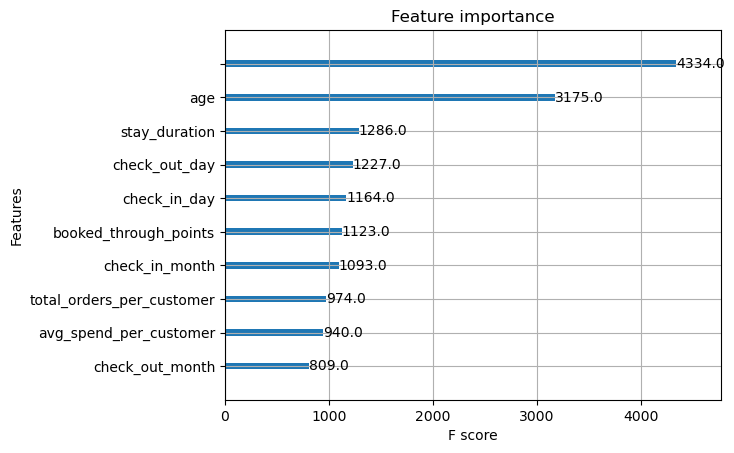

In [118]:
# Plot Feature Importance
import matplotlib.pyplot as plt

xgb.plot_importance(xgb_model, max_num_features=10)
plt.show()

In [119]:
# Print evaluation metrics
print(f'Accuracy: {accuracy:.4f}')

Accuracy: 0.1559
